In [ ]:
import keras_cv # Нужно установить nightly версию, чтобы использовать Random Translation:
                # pip install git+https://github.com/keras-team/keras-cv.git --upgrade
                #
                # https://github.com/keras-team/keras-cv/issues/291
                # https://github.com/keras-team/keras-cv/pull/1480
                #
                # RandomRotation и тд всё ещё не починены, я их не использую

import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_datasets as tfds

from matplotlib import pyplot as plt
import numpy as np

In [ ]:
ds_train, ds_test = tfds.load(name='mnist', split=['train', 'test'], as_supervised=True)

def normalize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    return tf.cast(image, tf.float32) / 255., label

ds_train = ds_train.map(normalize_img)
ds_test = ds_test.map(normalize_img)

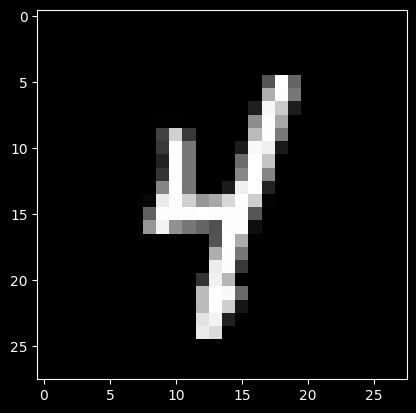

In [22]:
one_img = ds_train.take(1).get_single_element()[0]
plt.imshow(one_img, cmap='gray')

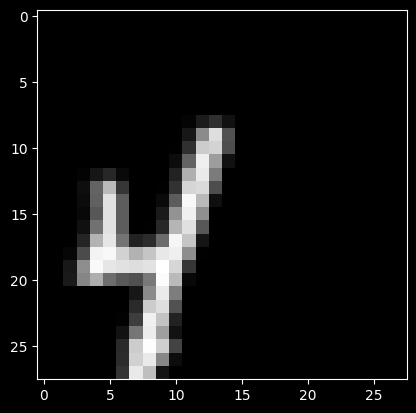

In [27]:
plt.imshow(
    keras_cv.layers.RandomTranslation(0.25, 0.25)(one_img[None, ...])[0],
    cmap='gray'
)

In [4]:
# Максимально возможная взаимная информация
np.log(10)

2.302585092994046

In [5]:
def make_model():
    inputs = tf.keras.Input(shape=(28, 28, 1))

    transformation = keras_cv.layers.RandomTranslation(0.25, 0.25, fill_mode = 'constant') # not tf.keras.layers.RandomTranslation, т.к. он работает медленно и генерирует предупреждения по типу Using a while_loop for converting RngReadAndSkip cause there is no registered converter for this op.
    transformed_inputs = transformation(inputs)

    submodel = tf.keras.Sequential([
        tf.keras.layers.Conv2D(8, 5, padding='same', activation='relu'),
        tf.keras.layers.Conv2D(8, 5, padding='same', activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(10, activation='softmax')
    ])

    out = submodel(inputs)
    out_transformed = submodel(transformed_inputs)

    # outer product
    mutual_inf_before_averaging = \
        tf.einsum('bi, bj -> bij', out, out_transformed)
    return tf.keras.Model(inputs=inputs, outputs=mutual_inf_before_averaging)

In [6]:
model = make_model()

In [7]:
def negative_mutual_inf(y_true: tf.Tensor, y_pred: tf.Tensor):
    """Усредняет по batch матрицу совместного распределения, и вычисляет по ней взаимную информацию.
        y_pred: batch_size * n_classes * n_classes
        y_true: batch_size
    Аргумент y_true нужен для совместимости с tf.Model.fit, но не используется.
    """
    joint_p = tf.math.reduce_mean(y_pred, axis=0)
    joint_p = (joint_p + tf.transpose(joint_p)) / 2
    P_i = tf.math.reduce_sum(joint_p, axis=1, keepdims=True)
    P_j = tf.math.reduce_sum(joint_p, axis=0, keepdims=True)
    eps = tf.keras.backend.epsilon()
    return tf.math.reduce_sum(
        joint_p * tf.math.log((P_i * P_j + eps) / (joint_p + eps)) # +eps, чтобы избежать деления на 0
    )

In [8]:
model.compile(loss=negative_mutual_inf, optimizer=tf.keras.optimizers.legacy.Adam()) # not tf.keras.optimizers.Adam(), т.к. он не работает с tensorflow-macos

In [9]:
model.fit(ds_train.batch(1000), epochs=10)

Epoch 1/10


2023-03-21 14:55:14.716901: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


60/60 [==============================] - 5s 72ms/step - loss: -0.1207
Epoch 2/10
60/60 [==============================] - 4s 72ms/step - loss: -0.7800
Epoch 3/10
60/60 [==============================] - 4s 72ms/step - loss: -0.8502
Epoch 4/10
60/60 [==============================] - 4s 70ms/step - loss: -0.8900
Epoch 5/10
60/60 [==============================] - 4s 70ms/step - loss: -0.9311
Epoch 6/10
60/60 [==============================] - 4s 70ms/step - loss: -0.9493
Epoch 7/10
60/60 [==============================] - 4s 70ms/step - loss: -0.9795
Epoch 8/10
60/60 [==============================] - 4s 70ms/step - loss: -0.9996
Epoch 9/10
60/60 [==============================] - 4s 70ms/step - loss: -1.0182
Epoch 10/10
60/60 [==============================] - 4s 69ms/step - loss: -1.0039


In [10]:
def extract_predictions(joint_p):
    return tf.math.reduce_sum(joint_p, axis=1)

In [11]:
preds = extract_predictions(model.predict(ds_test.batch(1000)))

 4/10 [===========>..................] - ETA: 0s

2023-03-21 14:55:57.620672: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


10/10 [==============================] - 0s 23ms/step


In [12]:
preds[0]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([3.3463256e-20, 0.0000000e+00, 1.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 2.4424224e-26, 0.0000000e+00,
       1.6816652e-18, 0.0000000e+00], dtype=float32)>

In [20]:
# model.save('model1.h5')

In [14]:
# model = make_model()
# model.load_weights('model1.h5')

In [15]:
predicted_classes = tf.math.argmax(preds, axis=1)

In [16]:
predicted_classes[0]

<tf.Tensor: shape=(), dtype=int64, numpy=2>

In [17]:
labels = np.array([label for _, label in ds_test])

output_probabilities = np.array(
    [tf.reduce_mean(preds[labels == cls], axis=0) for cls in range(10)]
)

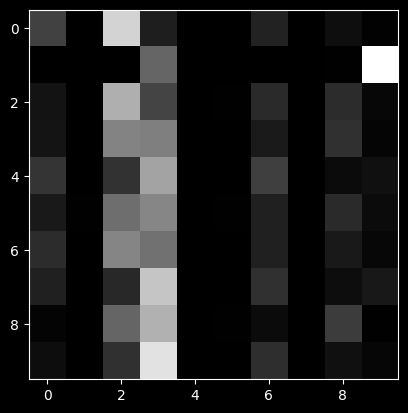

In [18]:
plt.imshow(output_probabilities, cmap='gray')
# Строки: настоящие классы
# Столбцы: предсказанные классы

# p[i, j] - усреднённая вероятность того, что модель предсказала класс j, когда на самом деле класс i

# В идеальном случае матрица, в которой в каждой строке и в каждом столбце один из элементов равен 1, а остальные равны 0

In [19]:
# Цифру 1 хорошо различает.

# Некоторые классы не выдаёт никогда